## Loading and Plotting Test Accuracies and Losses

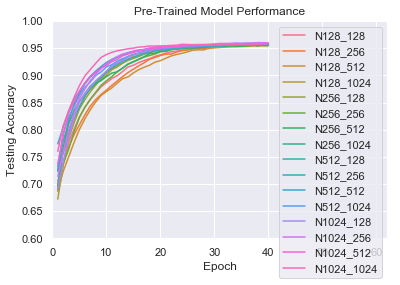

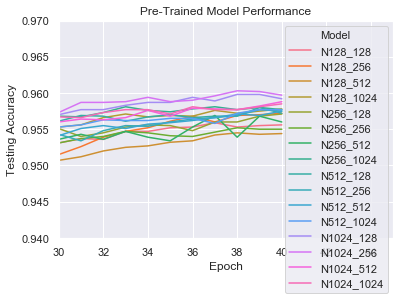

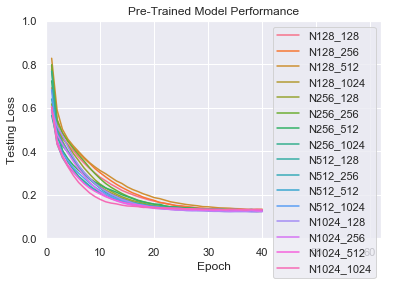

In [54]:
import numpy as np
ModelList = ['N128_128' ,'N128_256' ,'N128_512' ,'N128_1024' ,
             'N256_128' ,'N256_256' ,'N256_512' ,'N256_1024' ,
             'N512_128' ,'N512_256' ,'N512_512' ,'N512_1024' ,
             'N1024_128','N1024_256','N1024_512','N1024_1024',]

# Initialize variables and preallocate memory space
Epochs = 40
ModelCt = len(ModelList)
TestAccuracies = np.zeros([5*ModelCt,40])
TestLosses = np.zeros([5*ModelCt,40])

# Import CSV data from feature extraction architecture experiments
for i in range(ModelCt):
    TestAccuracies[i*5:(i+1)*5,:] = np.genfromtxt('DenseNodes/'+str(ModelList[i][1:])+'_TestAcc.csv', delimiter=',')
    TestLosses[i*5:(i+1)*5,:] = np.genfromtxt('DenseNodes/'+str(ModelList[i][1:])+'_TestLoss.csv', delimiter=',')
    
# Flatten or concatenate data for dataframe
All_Accuracies = TestAccuracies.flatten()
All_Losses = TestLosses.flatten()
Epochs = np.array(list(np.arange(1,Epochs+1))*5*ModelCt)
Models = np.repeat(ModelList, [200]*ModelCt, axis=0)

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Set up DataFrame for testing accuracy and testing loss
AccuracyPerformanceData = {'Epoch': Epochs, 'Testing Accuracy': All_Accuracies, 'Model': Models}
AccuracyPerformanceDf = pd.DataFrame(data=AccuracyPerformanceData)

LossPerformanceData = {'Epoch': Epochs, 'Testing Loss': All_Losses, 'Model': Models}
LossPerformanceDf = pd.DataFrame(data=AccuracyPerformanceData)

# Print plots 
plt.figure(1)
AccuracyPerformancePlt = sns.lineplot(x="Epoch", y="Testing Accuracy", hue="Model", ci = None, data=AccuracyPerformanceData)
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6,1) 
plt.xlim(0,62)
plt.savefig('TestAccuracyGraph.png', dpi = 600)
plt.show()

plt.figure(2)
AccuracyPerformancePlt = sns.lineplot(x="Epoch", y="Testing Accuracy", hue="Model", ci = None, data=AccuracyPerformanceDf[AccuracyPerformanceDf.Epoch >=30])
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.94,0.97) 
plt.xlim(30,45)
plt.savefig('ZoomInTestAccuracyGraph.png', dpi = 600)
plt.show()

plt.figure(3)
LossPerformancePlt = sns.lineplot(x="Epoch", y="Testing Loss", hue="Model", ci = None, data=LossPerformanceData)
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Loss')
plt.xlabel('Epoch')
plt.ylim(0,1) 
plt.xlim(0,62)
plt.savefig('TestLossGraph.png', dpi = 600)
plt.show()

## Calculate Other Performance Measures
Sensitivity, Specificity, Positive Predictivity, Negative Predictivity, AUC, F1 Score, MCC Score

In [45]:
# Import library
from statistics import mean
from statistics import stdev
import csv
from sklearn import metrics

# List of models to examine
Model = ['N128_128' ,'N128_256' ,'N128_512' ,'N128_1024' ,
         'N256_128' ,'N256_256' ,'N256_512' ,'N256_1024' ,
         'N512_128' ,'N512_256' ,'N512_512' ,'N512_1024' ,
         'N1024_128','N1024_256','N1024_512','N1024_1024',]

# Find TPR and FPR values closest to 0.5 threshold
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for j in range(len(Model)):

    # Calculate relevant measurements at threshold = 0.5
    Ind,  F1,   MCC, Acc  = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    Sens, Spec, PPV, NPV  = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    TP,   TN,   FN,  FP   = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    AUC = [0,0,0,0,0]

    # Load thresholds
    with open('DenseNodes/'+Model[j][1:]+'_Thresholds.csv', newline='') as f:
        Th = list(csv.reader(f))
    for i in range(5):
        Th[i] = list(map(float, Th[i])) 

    # Load TPR
    with open('DenseNodes/'+Model[j][1:]+'_TPR.csv', newline='') as f:
        TPR = list(csv.reader(f))
    for i in range(5):
        TPR[i] = list(map(float, TPR[i])) 

    # Load FPR
    with open('DenseNodes/'+Model[j][1:]+'_FPR.csv', newline='') as f:
        FPR = list(csv.reader(f))
    for i in range(5):
        FPR[i] = list(map(float, FPR[i])) 

    # Find index at 0.5 threshold
    for i in range(5):
        AUC[i] = metrics.auc(FPR[i],TPR[i])
        Ind[i] = find_nearest_index(Th[i], 0.5)
        Sens[i] = TPR[i][Ind[i]]
        Spec[i] = 1-FPR[i][Ind[i]]
        Acc[i] = (Sens[i]+Spec[i])/2
        TP[i] = np.round(Sens[i]*5000)
        TN[i] = np.round(Spec[i]*5000)
        FN[i] = 5000-TP[i]
        FP[i] = 5000-TN[i]
        PPV[i] = TP[i]/(TP[i]+FP[i])
        NPV[i] = TN[i]/(TN[i]+FN[i])
        F1[i] = 2*PPV[i]*Sens[i]/(PPV[i]+Sens[i])
        MCC[i] = (TP[i]*TN[i]-FP[i]*FN[i])/((TP[i]+FP[i])*(TP[i]+FN[i])*(TN[i]+FP[i])*(TN[i]+FN[i]))**(0.5)

    # Print out results
    print('Model:',Model[j])
    print('Accuracy:',round(mean(Acc),4),'+',round(stdev(Acc),4))
    print('AUC:',round(mean(AUC),4),'+',round(stdev(AUC),4))
    print('Sensitivity:',round(mean(Sens),4),'+',round(stdev(Sens),4))
    print('Specificity:',round(mean(Spec),4),'+',round(stdev(Spec),4))
    print('PPV:',round(mean(PPV),4),'+',round(stdev(PPV),4))
    print('NPV:',round(mean(NPV),4),'+',round(stdev(NPV),4))
    print('F1:',round(mean(F1),4),'+',round(stdev(F1),4))
    print('MCC:',round(mean(MCC),4),'+',round(stdev(MCC),4))
    print('')

Model: N128_128
Accuracy: 0.9553 + 0.0025
AUC: 0.9903 + 0.0021
Sensitivity: 0.9482 + 0.0119
Specificity: 0.9624 + 0.0106
PPV: 0.9621 + 0.0098
NPV: 0.9491 + 0.0107
F1: 0.955 + 0.0027
MCC: 0.911 + 0.0049

Model: N128_256
Accuracy: 0.9575 + 0.0032
AUC: 0.9905 + 0.0017
Sensitivity: 0.955 + 0.01
Specificity: 0.96 + 0.0107
PPV: 0.9599 + 0.01
NPV: 0.9554 + 0.0092
F1: 0.9574 + 0.0032
MCC: 0.9151 + 0.0065

Model: N128_512
Accuracy: 0.9541 + 0.0023
AUC: 0.9898 + 0.0016
Sensitivity: 0.9494 + 0.0115
Specificity: 0.9588 + 0.0146
PPV: 0.9587 + 0.0137
NPV: 0.9501 + 0.0101
F1: 0.9539 + 0.0019
MCC: 0.9084 + 0.0047

Model: N256_128
Accuracy: 0.9575 + 0.0033
AUC: 0.9908 + 0.0019
Sensitivity: 0.9468 + 0.008
Specificity: 0.9682 + 0.0069
PPV: 0.9676 + 0.0067
NPV: 0.9479 + 0.0072
F1: 0.957 + 0.0034
MCC: 0.9152 + 0.0065

Model: N256_256
Accuracy: 0.9553 + 0.0023
AUC: 0.9898 + 0.0012
Sensitivity: 0.9458 + 0.006
Specificity: 0.9648 + 0.0074
PPV: 0.9642 + 0.0071
NPV: 0.9469 + 0.0053
F1: 0.9549 + 0.0022
MCC: 0.91

## Generate ROC Curves
We will not generate neat plots for this since the ROC is too good to be worth plotting anyways. It'll just all look like a bunch of sharp corners. It is sufficient to just report sensitivity and specificity. 